# Analyse de données de parcours vélo

## 1. Présentation du modèle de calcul de puissance

L'idée est de créer un outil d'analyse de performances à vélo a partir des données fournies par Garmin. Ce genre d'outils existe probablement déjà, mais je suis actuellement en stage et je dois bien m'occuper pendant la journée.

Le but est donc de créer, à l'aide d'un Notebook, une interface simple pour enregistrer ses données de courses et en afficher l'analyse. Le principal enjeux de ce projet est l'analyse de la puissance développée par le coureur. En effet, les capteurs de puissance sont un dispositif moderne qui permet d'estimer, en calculant la pression exercée par le coureur sur la pédale et la cadence de pédalage, la puissance développée par le coureur en Watts. Ce dispositif est depuis quelques années déjà présent sur les vélos des cyclistes professionnels, car ils peuvent servir à estimer leur état de fatigue.

En effet, un cycliste connait sa fréquence cardiaque en fonction de la puissance qu'il développe. Lorsque le coureur atteint un stade de fatigue avancé, la fréquence cardiaque chute drastiquement, ce qui permet aux coureurs de savoir s'ils ont *les jambes* pour attaquer.

Toutefois, ce dispositif extrêmement important à haut niveau coûte encore très cher (1400€). Or, cette puissance dévelopée peut être estimée  gratuitement (après la lecture de nombreux papier scientifiques à ce sujet) de manière relativement précise (si on ne tiens pas compte du fait qu'un cycliste peut être dans l'aspiration d'un autre cycliste devant lui, ce qui n'a de toute façon que peu d'importance dans la montagne, là où le capteur est le plus important).

### 1.1. Calculs d'energies

La puissance est une grandeur qui quantifie les transfert d'energie au cours du temps. Par exemple, lorsqu'un vélo descend une pente, son énergie potentielle (proportionnelle à son altitude) est transformée en énergie cinétique (proportionnelle au carré de sa vitesse). A cela s'ajoute les forces de frottement qui transfèrent l'énergie cinétique du cycliste (qui est donc ralentit par les frottements) à l'air (l'air est mis en mouvement par le passage du cycliste).

Pour cette raison, notre estimation de la puissance développée par un cycliste se base sur des bilans énergétiques.

#### 1.1.1. Bilan énergétique et bilan de puissance

Faisons un bilan des forces à notre cycliste.

$$
m*a = F_{pédalage} + F_{gravité} + F_{frottements} 
$$
avec $m$ la *masse* du cycliste, $a$ son accélération et $F$ les forces qu'il subit.

Cette équation se traduit de la manière suivante pour faire apparaître des puissances :

$$
\Delta E_c + \Delta E_p = (P_{pédalage} + P_{frottements})*t
$$

avec :
- $E_c = \frac{1}{2}mv^2$ l'énergie cinétique du cycliste (v étant la *vitesse* du cycliste)
- $E_p = mgz$ l'énerige potentielle de pesanteur (g est l'*accélération* de la pesanteur, soit l'accélération que subit un objet en chute libre, et a est l'altitude du cycliste)
- $P_{pédalage}$ le nombre de Watt produits par le cycliste
- $P_{frottements} = -F_{frottements}*v$ la puissance des forces de frottements (négative)
- t le temps
  
Ainsi, si les forces de frottements son plus importantes que la puissance développée par le cycliste, celui-ci aura tendance à perdre de l'énergie et ralentir. Puisque la montre Garmin fourni la vitesse et l'altitude du cycliste, les énergies cinétique et potentielle sont aisées à déterminer. 

Afin de résoudre notre bilan de puissance et déterminer $P_{pédalage}$, il suffit donc de déterminer $F_{frottements}$.

#### 1.1.2. Estimation de la trainée

Pour déterminer les forces de frottements (aussi appelée *trainée*, ou *drag* en anglais), on utilise les résultats de la mécanique des fluides : 

$$F_{drag}=\frac{1}{2}*C_d*\rho*v^2*A$$

avec:
- $\rho$ la densité volumique de l'air
- $A$ la *projected frontal area* autrement dit la surface que le cycliste offre au vent
- $C_d$ le coefficient de trainée

La thermodynamique permet d'estimer la densité volumique de l'air en fonction de l'altitude du cycliste. Quand à $A$ et $C_d$, ce sont des facteurs aérodynamiques qui dépendent de la taille et de la position du coureur sur le vélo.

#### 1.1.3. Estimation de la *projected frontal area*

La *projected frontal area* (PFA) est la surface que le cycliste offre au vent. Un cycliste que se tient droit sur son vélo offre plus de prise au vent est est plus ralentit, ce qui se traduit dans les équations par un $A$ plus important, ce qui augmente la force de frottement. Un cycliste en position aérodynamique, recroquevillé sur lui-même, présente une moins importante surface au vent, est moins ralenti et va donc plus vite.

Toutefois, cette surface n'est pas évidente à déterminer. Il est possible de l'estimer à partir d'une photo du cycliste prise de face, mais l'utilisation d'un tel procédé serait un peu fastidieuse. Heureusement, puisque la question de l'aérodynamisme d'un cycliste est très étudiée aujourd'hui, différents modèles ont été développés pour estimer la PFA à partir de la taille et du poids du cycliste. La formule qui donne ce résultat est la suivante :
0.0293 * (size**0.725) * (mass**0.425) + 0.0604

$$
PFA = 0.0293*taille^{0.725}*masse^{0.425} + 0.0604
$$

#### 1.1.4. Estimation du coefficient de trainée

Enfin, il reste à estimer le coefficient de trainée. Celui-ci ne peut être approximé que très grossièrement car il dépend grandement de la position du cycliste. En effet, la force de frottement est créée par les turbulences que le cycliste génère dans son sillage. Une position qui *fend* l'air produit moins de turbulance et réduit donc la force de frottements.

Un autre exemple intéressant est la position des jambes. Des simulations et des essais dans des souffleries montrent qu'avoir les pédale à l'horizontal (et donc avoir les deux jambes pliées de manière similaire) permet l'émergence d'un flux symétrique qui réduit les turbulences, et donc le coefficient de frottement, à l'inverse d'une position avec une jambe tendue et une jambe pliée.

Le coefficient de frottement dépend aussi de la forme du cadre du vélo, de la forme des roues (roue pleine ou non), des vêtements du cycliste... Dans la suite on choisira $C_d=1.0$ et on s'en contentera. Il s'agit du coefficient en position relevée ou en position *dropped*. En position *time-trial*, avec des prolongateurs, ce coefficient descend à $C_d=0.8$.

### 1.2. Limites du modèle

Notre modèle se base donc sur l'estimation de différents coefficients clefs à l'aide des résultats obtenus par des testes en souffleries et des simulations informatiques. Certaines approximations sont peut-être un peu brutales, ce qui justifie l'utilisation de capteurs de puissance au niveau des pédales, qui, eux, donnent toujours un résultat exact, mais notre approximation reste de relativement bonne qualité.

Toutefois deux facteurs on été ommis dans cette étude, et sont d'une grande importance et faussent les résultats. Premièrement le vent n'est pas considéré ici. Un cycliste qui roule à 20km/h avec un vent de face de 20km/h subit la même force de frottement qu'un cycliste qui roule à 40km/h. Malheureusement il est impossible de prendre le vent en compte dans cette étude. Deuxièmement, le coefficient de trainée d'un coureur qui dans l'aspiration d'un autre coureur est jusqu'à deux fois inférieur à la normale. De même, impossible de prendre cet effet en compte.

On ommet aussi des facteurs moins importants, comme les frottements dus au contact entre le vélo et la route, ainsi qu'entre les différentes pièces mécaniques du vélo, mais ceci représentent une part suffisamment minime du bilan énergétique pour qu'elles soient ignorées. On néglige aussi l'énergie liée à la mise en rotation de la roue pour la même raison.

En résumé, ce modèle est un très bon indicateur de la puissance du cycliste à part quand il y a un fort vent ou quand le cycliste prend l'aspiration d'un autre cycliste sur du plat (en montée, la vitesse des coureurs est suffisamment faible pour que l'impact des forces de frottements soient moins importante). Mais même dans ce cas là, les données devraient nous permettre d'obtenir des analyses cohérentes des zones de puissance.

## 2. Analyse des performances

A l'aide de ces données, il va être possible d'estimer certain indicateurs qui peuvent être utilisés pour quantifier la forme physique ou la fatigue du cycliste. Ces indicateurs se basent sur les données présentes dans le fichier *.fit*, à savoir la fréquence cardiaque ainsi que la puissance. Il est difficile de créer des indicateurs de bonne qualité sans avoir accès à plus de données, et sur une simple sortie vélo (ces indicateurs sont souvent censés être calculés lors de tests bien définis). A la place, nous disposons généralement d'une longue sortie vélo, où le cycliste conserve sont énergies, ce qui conduit à une sous-estimation des indicateurs basés sur des puissances maximales.

### 2.1. Peak Power Output

La *Peak Power Output* (PPO) est une mesure de la puissance maximale qu'un cycliste peu produire. Techniquement, le test pour déterminer cette grandeur est le suivant : faire effectuer une série de tests de 150s où le cycliste doit maintenir une certaine puissance, augmenter cette puissance au fur et à mesure, et lorsque le cycliste ne peut plus c'est qu'on a atteint la PPO. A défaut d'être dans les conditions optimales pour effectuer le test, on se contentera dand le suite d'estimer la PPO en cherchant le maximum de puissance maintenu pendant 150s.

Les meilleurs sprinteurs peuvent produire jusqu'à 2000W.

### 2.2. $\text{VO}_{\text{2 MAX}}$

La $\text{VO}_{\text{2 MAX}}$ est la *consommation maximale d'oxygène*, soit le volume d'oxygène que le corps peu consommer lors d'un effort maximal. Cette grandeur s'exprime en L/min, mais pour tenir compte de la morphologie du sportif celle-ci est en réalité généralement exprimée en L/min/kg (après avoir divisé par la masse du cycliste). La $\text{VO}_{\text{2 MAX}}$ n'est en réalité par le meilleur indicateur de l'endurance d'un cycliste, mais il s'agit d'un indicateur couramment utilisé. Or il existe une forte corrélation entre la PPo et la $\text{VO}_{\text{2 MAX}}$, ce qui va nous permettre de l'estimer, grâce à la formule suivante:
$$\text{VO}_{\text{2 MAX}} = 0.01141*W_{\text{peak}} + 0.435$$

En divisant par la masse du cycliste et en convertissant en mL/min, il est ainsi possible d'estimer la $\text{VO}_{\text{2 MAX}}$. Toutefois, dû à la suite d'approximation dans l'estimation de cet indicateur, il n'est pas de très bonne qualité.

### 2.3. Functional Power Treshold

La *Fonctionnal Power Treshold* (FTP) est la puissance maximale qu'un cycliste peut produire pendant 1h. Ici, nous l'avons estimée en considérant qu'elle vaut 95% de la puissance maximale soutenue pendant 20 minutes. Toutefois, lorsqu'on étudie la production de watts, on préfère en général calculer les indicateurs en W/kg. Il existe des tests bien définis pour calculer la FTP de manière précise, mais nous ne disposons encore une fois pas de ces tests ici.

A titre de comparaison, la FTP d'un cycliste amateur se situe entre 1.5 et 2.5 W/kg, alors qu'un cycliste expérimenté à une FTP entre 3.0 et 4.5 W/kg. Les cycliste du tour de France, eux, possèdent une FTP de jusqu'à 7.0 W/kg.

## 3. Sources

1. <a href='https://www.researchgate.net/publication/51660070_Aerodynamic_drag_in_cycling_Methods_of_assessment'>Aerodynamic drag in cycling: Methods of assessment</a>
2. <a href='https://www.researchgate.net/publication/259742352_An_experimental_study_of_bicycle_aerodynamics'>An experimental study of bicycle aerodynamics</a>
3. <a href='https://link.springer.com/article/10.1007/s12283-017-0234-1'>Riding against the wind: a review of competition cycling aerodynamics</a>
4. <a href='https://www.researchgate.net/publication/225161766_The_understanding_and_development_of_cycling_aerodynamics'>The understanding and development of cycling aerodynamics</a>
5. <a href='https://link.springer.com/article/10.2165/00007256-200535040-00002'>The Science of Cycling — Physiology and Training — Part 1</a>
6. <a href='https://link.springer.com/article/10.1007/bf01466278'>Peak power output predicts maximal oxygen uptake and performance time in trained cyclists</a>

## 4. Graphiques

Il est temps d'appliquer cette belle théorie à des sorties vélo. Les graphes suivants sont similaires à ceux qu'on peut obtenir à partir de Garmin Connect, mais des données de puissance y sont ajoutées.

### 4.1. Collecte des données

Avant de commencer l'analyse, il faut enregistrer le fichier *.fit* qui contient les données de la sortie vélo dans <a href='activites'>ce dossier</a>. Ce fichier *.fit* peut être téléchargé depuis <a href='https://connect.garmin.com/modern/activities?activityType=cycling'>Garmin Connect</a> (sélectionner l'activité à télécharger, et chercher *Exporter au format original* ou *Exporter en FIT*).

Une fois que le fichier est présent dans le dossier, executer la cellule ci-dessous en la modifiant de la manière suivante : 

```python
filename = "nom_du_fichier.fit"
poids = 70 # poids du cycliste en kg
taille = 180 # taille du cycliste en cm
```

In [1]:
filename = "exemple.fit"
poids = 70
taille = 180

Ensuite, exécuter les cellules suivantes pour obtenir l'analyse de la sortie vélo.

In [2]:
from cycling_data import CyclingData
CyclingData.set_cyclist(poids,taille/100)
cd = CyclingData(filename)

### 4.2. Informations globales

In [3]:
cd.show_map()
cd.show_global_informations()


<center>

| Durée de l'activité | Distance parcourue | Vitesse moyenne | Vitesse maximale | Dénivelé Positif | FC Moyenne | Energie totale produite | PPO | FTP | VO2MAX (mL/kg/min) |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| 2:18:45 | 50.29 km | 21.7 km/h | 54 km/h | 867 m | 142 bpm | 981 kJ | 261 W | 226 W | 49 |

</center>
            
        

### 4.3. Profil de la sortie

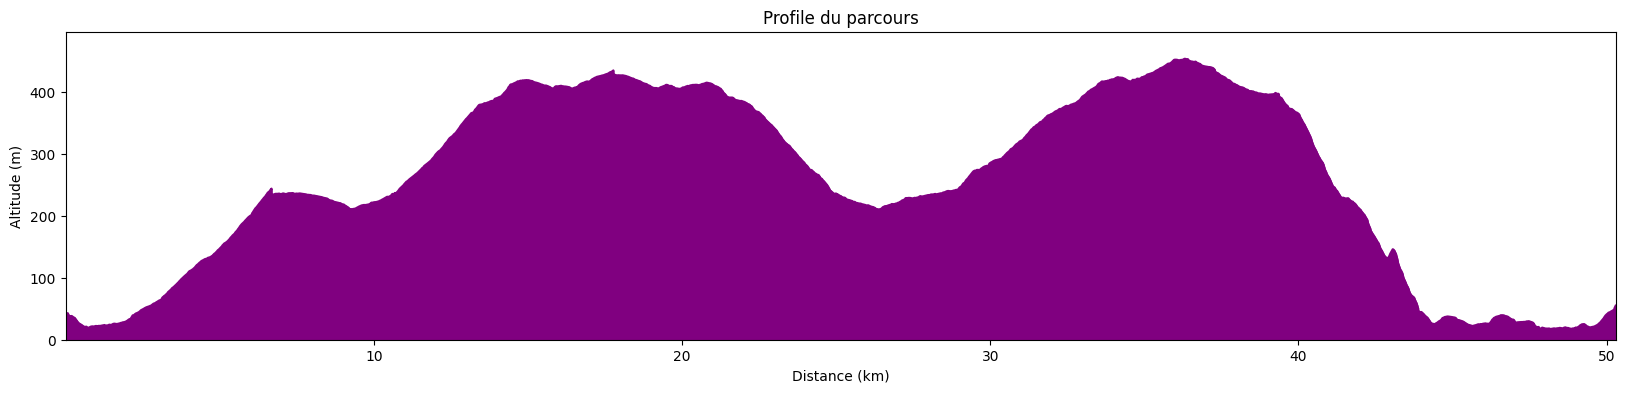

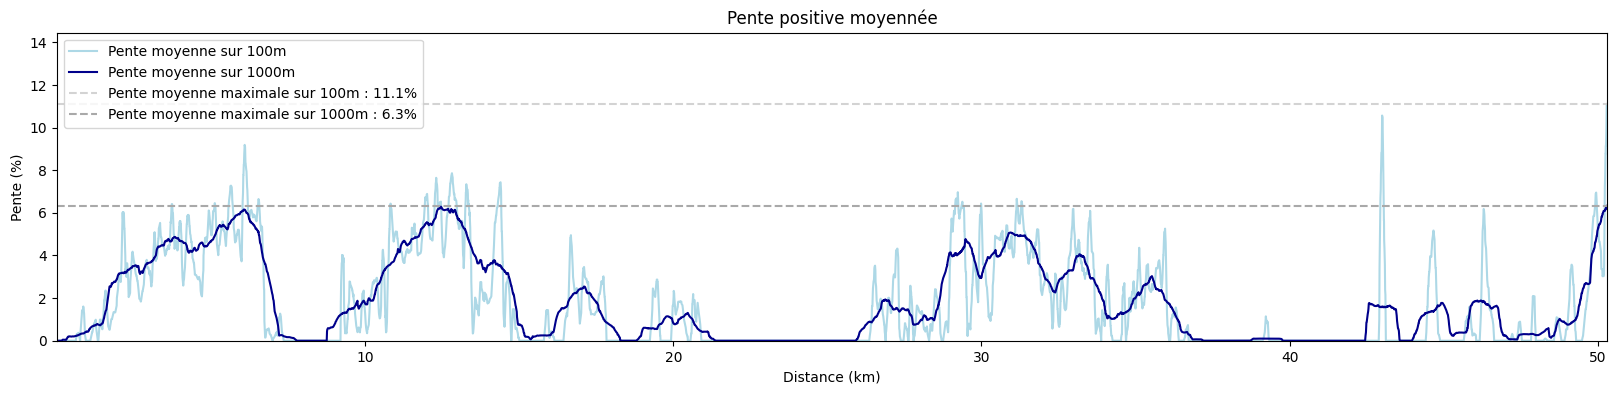

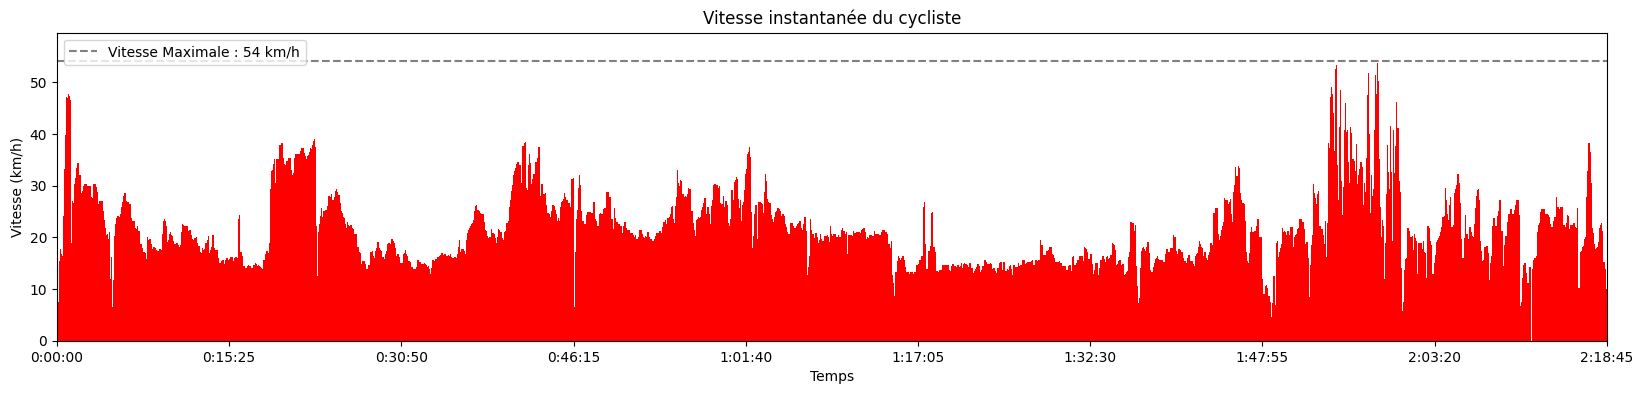

In [4]:
cd.show_profile()
cd.show_slope()
cd.show_speed()

### 4.4. Graphes de performances

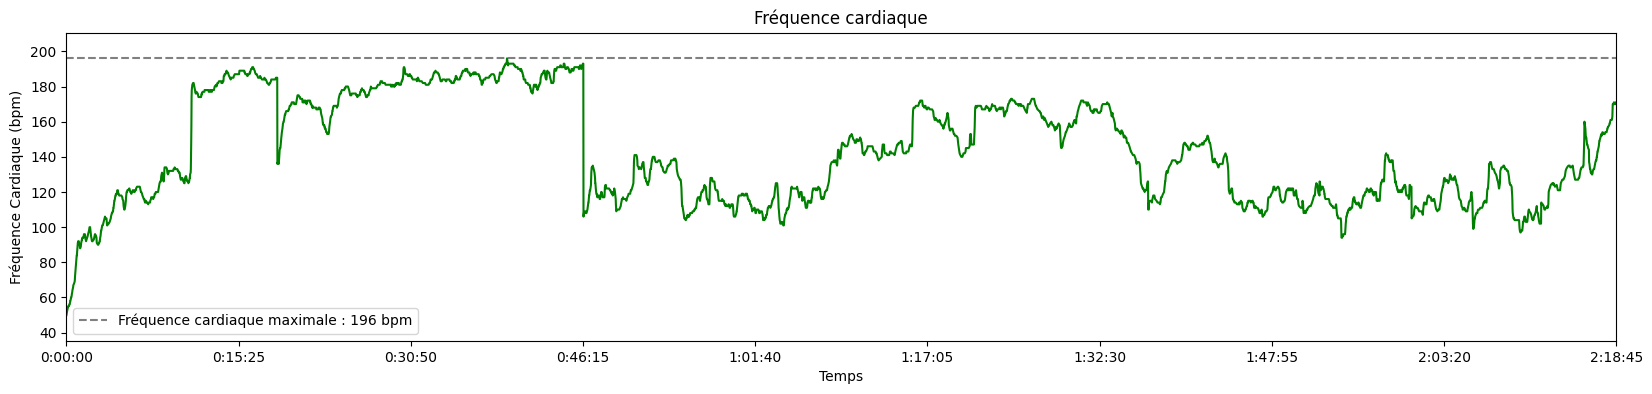

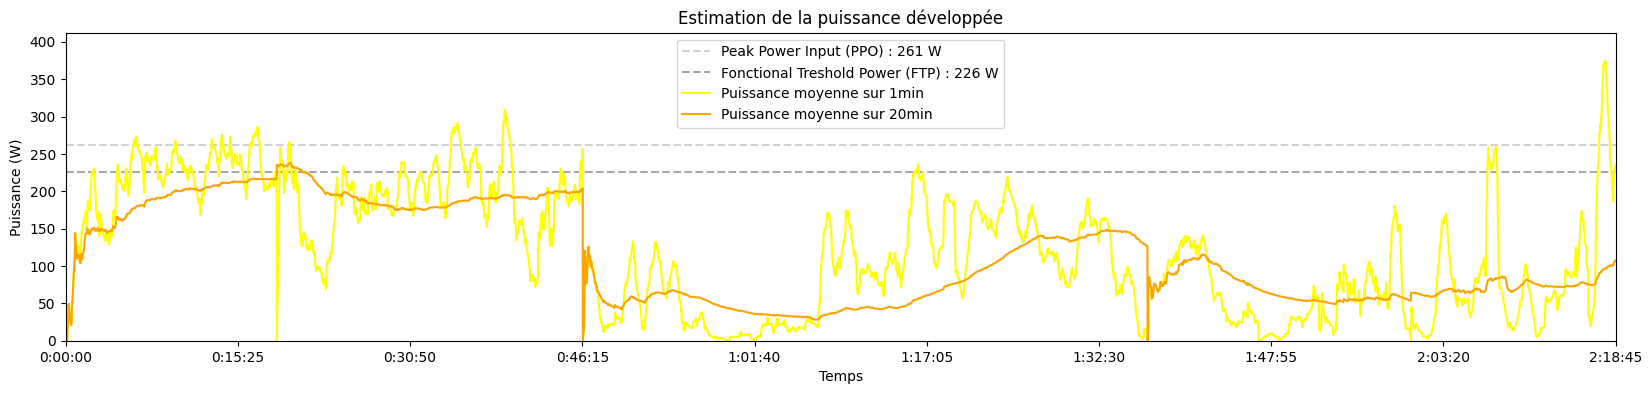

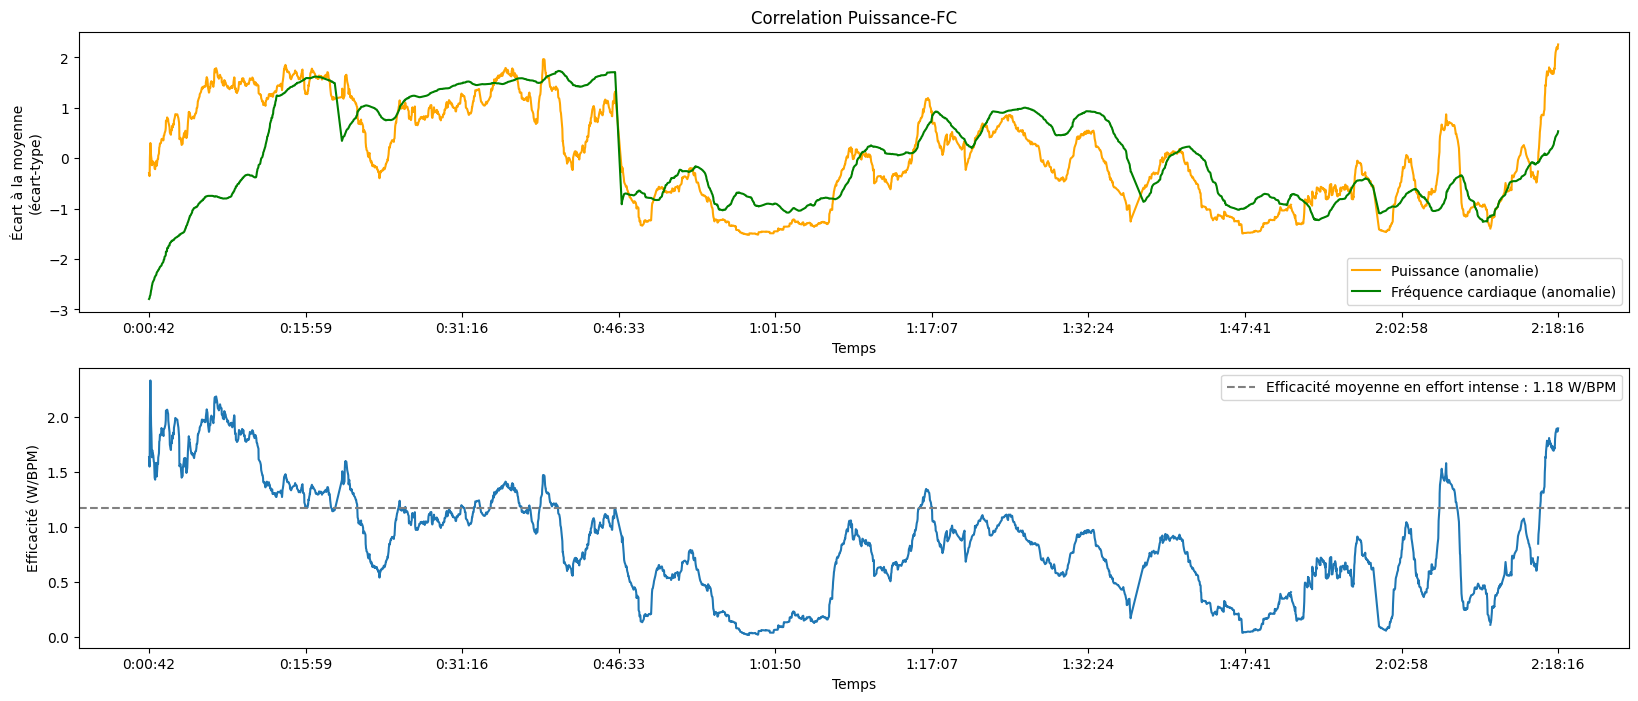

In [5]:
cd.show_cardiac_frequency()
cd.show_watts()
cd.show_efficiency()